## 📚 Kütüphaneleri İçe Aktarma

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# Görselleştirme ayarları
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✅ Kütüphaneler yüklendi')

✅ Kütüphaneler yüklendi


## 📂 Veri Yükleme

In [2]:
# Cleaned data'yı yükle
df = pd.read_csv('../data/processed/cleaned_data.csv', parse_dates=['capture_date'])

print('✅ Veriler yüklendi')
print(f'\n📊 Dataset Bilgileri:')
print(f'   • Toplam Kayıt: {len(df):,}')
print(f'   • Sütun Sayısı: {df.shape[1]}')
print(f'   • Benzersiz Ürün: {df["product_name"].nunique():,}')
print(f'   • Tarih Aralığı: {df["capture_date"].min().strftime("%d/%m/%Y")} - {df["capture_date"].max().strftime("%d/%m/%Y")}')

✅ Veriler yüklendi

📊 Dataset Bilgileri:
   • Toplam Kayıt: 44,495
   • Sütun Sayısı: 17
   • Benzersiz Ürün: 1,579
   • Tarih Aralığı: 09/01/2024 - 13/04/2024


In [10]:
# İlk 5 satıra bakalım
df.head()

,product_name,supermarket_name,category_name,price_gbp,price_unit_gbp,unit,price_category,capture_date,year,month,month_name,day,day_of_week,day_name,week,is_weekend,is_own_brand
0,19 Crimes Chardonnay,Morrisons,drinks,9.0,11.97,l,Pahalı,2024-03-22,2024,3,March,22,4,Friday,12,0,False
1,19 Crimes Chardonnay,Morrisons,drinks,9.0,11.97,l,Pahalı,2024-04-06,2024,4,April,6,5,Saturday,14,1,False
2,19 Crimes Chardonnay,Morrisons,drinks,9.0,11.97,l,Pahalı,2024-04-04,2024,4,April,4,3,Thursday,14,0,False
3,19 Crimes Chardonnay,Morrisons,drinks,8.0,10.64,l,Pahalı,2024-02-24,2024,2,February,24,5,Saturday,8,1,False
4,19 Crimes Chardonnay,Morrisons,drinks,8.0,10.64,l,Pahalı,2024-02-22,2024,2,February,22,3,Thursday,8,0,False


---
## 🔧 PART 1: Veri Hazırlama

### 1.1 Clustering İçin Ürün Bazlı Özet Oluşturma

In [11]:
# Her ürün için ortalama özellikleri hesapla
product_summary = df.groupby(['product_name', 'supermarket_name', 'category_name']).agg({
    'price_gbp': ['mean', 'std', 'min', 'max', 'count'],
    'price_unit_gbp': ['mean'],
    'is_own_brand': ['max']  # 1 veya 0
}).reset_index()

# Sütun isimlerini düzelt
product_summary.columns = ['product_name', 'supermarket_name', 'category_name',
                           'price_mean', 'price_std', 'price_min', 'price_max', 'observation_count',
                           'price_unit_mean', 'is_own_brand']

# NaN std değerlerini 0 yap (tek gözlem için)
product_summary['price_std'] = product_summary['price_std'].fillna(0)

print(f'✅ Ürün özeti oluşturuldu: {len(product_summary):,} benzersiz ürün')
print(f'\n📊 Özet İstatistikler:')
print(product_summary[['price_mean', 'price_unit_mean', 'observation_count']].describe())

✅ Ürün özeti oluşturuldu: 3,784 benzersiz ürün

📊 Özet İstatistikler:
        price_mean  price_unit_mean  observation_count
count  3784.000000      3784.000000        3784.000000
mean      6.287226        21.572503          11.758721
std       9.881996       159.796761           6.993761
min       0.300000         0.001000           1.000000
25%       2.000000         0.995500           6.000000
50%       3.350000         4.000000          11.000000
75%       6.500000        11.330000          17.000000
max     150.000000      7755.600000          33.000000


### 1.2 Clustering Özellikleri Seçme ve Encoding

In [12]:
# Supermarket one-hot encoding
supermarket_dummies = pd.get_dummies(product_summary['supermarket_name'], prefix='supermarket')

# Category one-hot encoding
category_dummies = pd.get_dummies(product_summary['category_name'], prefix='category')

# Clustering için feature set oluştur
clustering_features = pd.concat([
    product_summary[['price_mean', 'price_std', 'price_unit_mean', 'is_own_brand', 'observation_count']],
    supermarket_dummies,
    category_dummies
], axis=1)

print(f'✅ Clustering özellikleri hazırlandı')
print(f'   • Toplam Feature: {clustering_features.shape[1]}')
print(f'   • Numerik: 5')
print(f'   • Supermarket One-Hot: {supermarket_dummies.shape[1]}')
print(f'   • Category One-Hot: {category_dummies.shape[1]}')

✅ Clustering özellikleri hazırlandı
   • Toplam Feature: 21
   • Numerik: 5
   • Supermarket One-Hot: 5
   • Category One-Hot: 11


### 1.3 Feature Scaling (Standardization)

In [13]:
# StandardScaler ile ölçeklendirme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clustering_features)

print('✅ Feature scaling tamamlandı')
print(f'\n📊 Scaled Data Shape: {X_scaled.shape}')
print(f'   • Mean: {X_scaled.mean():.4f} (0a yakın olmalı)')
print(f'   • Std: {X_scaled.std():.4f} (1e yakın olmalı)')

✅ Feature scaling tamamlandı

📊 Scaled Data Shape: (3784, 21)
   • Mean: -0.0000 (0a yakın olmalı)
   • Std: 0.9759 (1e yakın olmalı)


---
## 📊 PART 2: Optimal Cluster Sayısını Bulma (Elbow Method)

In [14]:
# Farklı K değerleri için inertia hesapla
print('🔍 Optimal cluster sayısı aranıyor...')

K_range = range(2, 11)
inertias = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    print(f'  K={k}: Inertia={kmeans.inertia_:.2f}')

print('\n✅ Hesaplama tamamlandı')

🔍 Optimal cluster sayısı aranıyor...
  K=2: Inertia=70633.72
  K=3: Inertia=65471.46
  K=4: Inertia=61883.56
  K=5: Inertia=56874.15
  K=6: Inertia=52956.13
  K=7: Inertia=48759.18
  K=8: Inertia=44683.99
  K=9: Inertia=40438.28
  K=10: Inertia=36459.08

✅ Hesaplama tamamlandı


💾 Grafik kaydedildi: 27_elbow_method.png


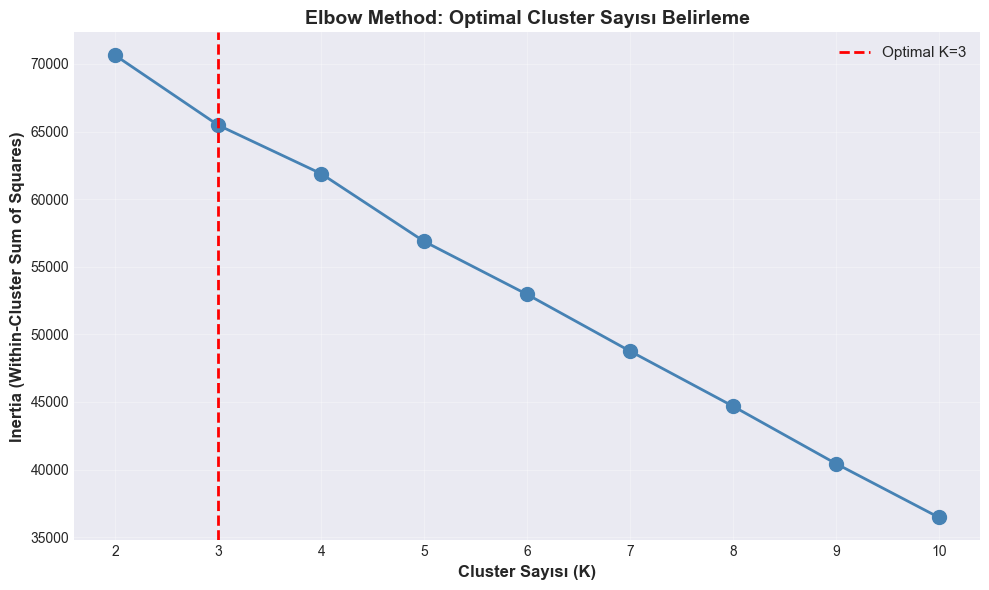


📊 Öneri: K=3 optimal cluster sayısı (Ekonomik/Orta/Premium)


In [15]:
# Elbow Method Grafiği
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(K_range, inertias, marker='o', linewidth=2, markersize=10, color='steelblue')
ax.set_xlabel('Cluster Sayısı (K)', fontweight='bold', fontsize=12)
ax.set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontweight='bold', fontsize=12)
ax.set_title('Elbow Method: Optimal Cluster Sayısı Belirleme', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_xticks(K_range)

# En iyi K'yi vurgula (K=3 veya K=4 genelde)
optimal_k = 3
ax.axvline(x=optimal_k, color='red', linestyle='--', linewidth=2, label=f'Optimal K={optimal_k}')
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig('../outputs/figures/27_elbow_method.png', dpi=300, bbox_inches='tight')
print('💾 Grafik kaydedildi: 27_elbow_method.png')
plt.show()

print(f'\n📊 Öneri: K={optimal_k} optimal cluster sayısı (Ekonomik/Orta/Premium)')

---
## 🎯 PART 3: K-Means Clustering (K=3)

In [16]:
# K=3 ile final model
print('🎯 K-Means modeli eğitiliyor (K=3)...')

optimal_k = 3
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_scaled)

# Cluster etiketlerini dataframe'e ekle
product_summary['cluster'] = clusters

print('✅ Clustering tamamlandı!')
print(f'\n📊 Cluster Dağılımı:')
print(product_summary['cluster'].value_counts().sort_index())

🎯 K-Means modeli eğitiliyor (K=3)...
✅ Clustering tamamlandı!

📊 Cluster Dağılımı:
cluster
0    1026
1     486
2    2272
Name: count, dtype: int64


### 3.1 Cluster Özelliklerini İnceleme

In [17]:
# Her cluster için istatistikler
print('='*80)
print('📊 CLUSTER ANALİZİ - DETAYLI RAPOR')
print('='*80)

cluster_labels = ['Ekonomik', 'Orta', 'Premium']  # Anlamlı isimler

for cluster_id in range(optimal_k):
    cluster_data = product_summary[product_summary['cluster'] == cluster_id]
    
    print(f'\n🏷️  CLUSTER {cluster_id} - {cluster_labels[cluster_id].upper()}')
    print('-'*80)
    print(f'   • Ürün Sayısı: {len(cluster_data):,} ({len(cluster_data)/len(product_summary)*100:.1f}%)')
    print(f'   • Ortalama Fiyat: £{cluster_data["price_mean"].mean():.2f}')
    print(f'   • Fiyat Aralığı: £{cluster_data["price_mean"].min():.2f} - £{cluster_data["price_mean"].max():.2f}')
    print(f'   • Ortalama Birim Fiyat: £{cluster_data["price_unit_mean"].mean():.2f}')
    print(f'   • Kendi Marka Oranı: {cluster_data["is_own_brand"].mean()*100:.1f}%')
    
    # En yaygın süpermarket
    top_supermarket = cluster_data['supermarket_name'].value_counts().head(3)
    print(f'   • En Yaygın Süpermarketler:')
    for sm, count in top_supermarket.items():
        print(f'     - {sm}: {count} ürün ({count/len(cluster_data)*100:.1f}%)')
    
    # En yaygın kategoriler
    top_category = cluster_data['category_name'].value_counts().head(3)
    print(f'   • En Yaygın Kategoriler:')
    for cat, count in top_category.items():
        print(f'     - {cat}: {count} ürün ({count/len(cluster_data)*100:.1f}%)')

print('\n' + '='*80)

📊 CLUSTER ANALİZİ - DETAYLI RAPOR

🏷️  CLUSTER 0 - EKONOMIK
--------------------------------------------------------------------------------
   • Ürün Sayısı: 1,026 (27.1%)
   • Ortalama Fiyat: £5.81
   • Fiyat Aralığı: £0.50 - £150.00
   • Ortalama Birim Fiyat: £36.23
   • Kendi Marka Oranı: 0.0%
   • En Yaygın Süpermarketler:
     - Sains: 1025 ürün (99.9%)
     - ASDA: 1 ürün (0.1%)
   • En Yaygın Kategoriler:
     - food_cupboard: 235 ürün (22.9%)
     - health_products: 232 ürün (22.6%)
     - drinks: 165 ürün (16.1%)

🏷️  CLUSTER 1 - ORTA
--------------------------------------------------------------------------------
   • Ürün Sayısı: 486 (12.8%)
   • Ortalama Fiyat: £6.61
   • Fiyat Aralığı: £0.36 - £57.20
   • Ortalama Birim Fiyat: £21.15
   • Kendi Marka Oranı: 0.0%
   • En Yaygın Süpermarketler:
     - Tesco: 486 ürün (100.0%)
   • En Yaygın Kategoriler:
     - drinks: 129 ürün (26.5%)
     - food_cupboard: 113 ürün (23.3%)
     - health_products: 87 ürün (17.9%)

🏷️  CLUSTE

### 3.2 Cluster İsimlendirme (Otomatik)

In [18]:
# Cluster'ları ortalama fiyata göre sırala ve isimlendir
cluster_avg_prices = product_summary.groupby('cluster')['price_mean'].mean().sort_values()

# Mapping oluştur
cluster_name_map = {
    cluster_avg_prices.index[0]: 'Ekonomik',
    cluster_avg_prices.index[1]: 'Orta',
    cluster_avg_prices.index[2]: 'Premium'
}

product_summary['cluster_name'] = product_summary['cluster'].map(cluster_name_map)

print('✅ Cluster isimlendirmesi tamamlandı')
print(f'\n📊 İsimlendirilmiş Cluster Dağılımı:')
print(product_summary['cluster_name'].value_counts())

✅ Cluster isimlendirmesi tamamlandı

📊 İsimlendirilmiş Cluster Dağılımı:
cluster_name
Orta        2272
Ekonomik    1026
Premium      486
Name: count, dtype: int64


---
## 📊 PART 4: Görselleştirmeler

### 4.1 Cluster Fiyat Dağılımı

💾 Grafik kaydedildi: 28_cluster_price_distribution.png


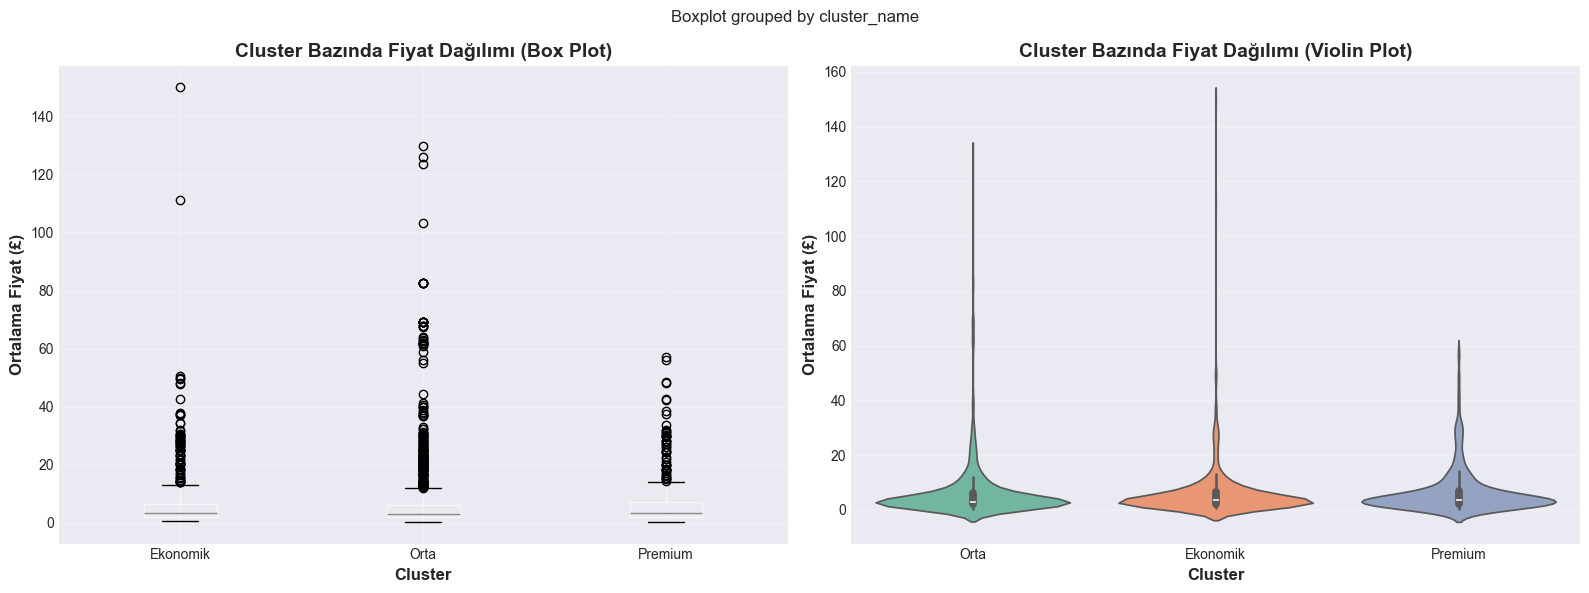

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot
product_summary.boxplot(column='price_mean', by='cluster_name', ax=axes[0])
axes[0].set_xlabel('Cluster', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Ortalama Fiyat (£)', fontweight='bold', fontsize=12)
axes[0].set_title('Cluster Bazında Fiyat Dağılımı (Box Plot)', fontweight='bold', fontsize=14)
axes[0].grid(True, alpha=0.3)
plt.sca(axes[0])
plt.xticks(rotation=0)

# Violin plot
sns.violinplot(data=product_summary, x='cluster_name', y='price_mean', ax=axes[1], palette='Set2')
axes[1].set_xlabel('Cluster', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Ortalama Fiyat (£)', fontweight='bold', fontsize=12)
axes[1].set_title('Cluster Bazında Fiyat Dağılımı (Violin Plot)', fontweight='bold', fontsize=14)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../outputs/figures/28_cluster_price_distribution.png', dpi=300, bbox_inches='tight')
print('💾 Grafik kaydedildi: 28_cluster_price_distribution.png')
plt.show()

### 4.2 Cluster Bar Chart (Ürün Sayıları)

💾 Grafik kaydedildi: 29_cluster_product_counts.png


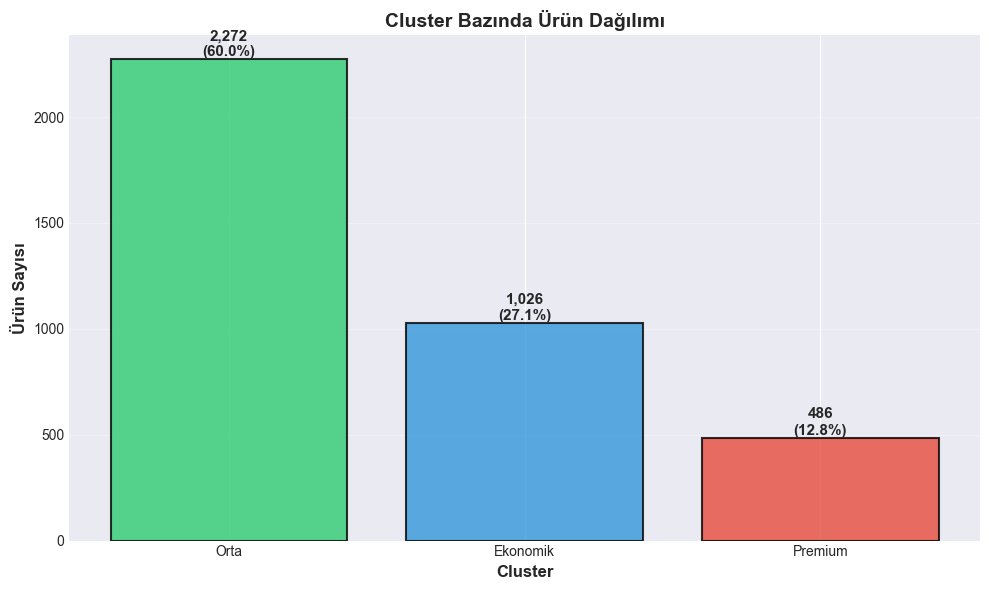

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

cluster_counts = product_summary['cluster_name'].value_counts()
colors = ['#2ecc71', '#3498db', '#e74c3c']  # Yeşil, Mavi, Kırmızı

bars = ax.bar(cluster_counts.index, cluster_counts.values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Değerleri bar üzerine yaz
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}\n({height/len(product_summary)*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.set_xlabel('Cluster', fontweight='bold', fontsize=12)
ax.set_ylabel('Ürün Sayısı', fontweight='bold', fontsize=12)
ax.set_title('Cluster Bazında Ürün Dağılımı', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../outputs/figures/29_cluster_product_counts.png', dpi=300, bbox_inches='tight')
print('💾 Grafik kaydedildi: 29_cluster_product_counts.png')
plt.show()

### 4.3 Süpermarket × Cluster Heatmap

💾 Grafik kaydedildi: 30_supermarket_cluster_heatmap.png


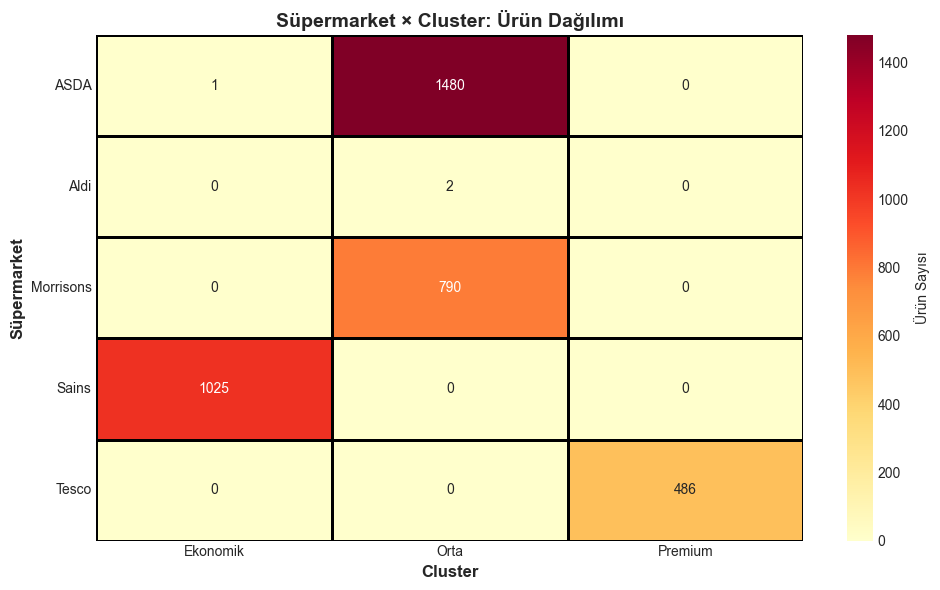

In [21]:
# Süpermarket ve cluster bazında ürün sayıları
supermarket_cluster = pd.crosstab(product_summary['supermarket_name'], 
                                   product_summary['cluster_name'])

fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(supermarket_cluster, annot=True, fmt='d', cmap='YlOrRd', 
            linewidths=1, linecolor='black', cbar_kws={'label': 'Ürün Sayısı'},
            ax=ax)

ax.set_xlabel('Cluster', fontweight='bold', fontsize=12)
ax.set_ylabel('Süpermarket', fontweight='bold', fontsize=12)
ax.set_title('Süpermarket × Cluster: Ürün Dağılımı', fontweight='bold', fontsize=14)
plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig('../outputs/figures/30_supermarket_cluster_heatmap.png', dpi=300, bbox_inches='tight')
print('💾 Grafik kaydedildi: 30_supermarket_cluster_heatmap.png')
plt.show()

### 4.4 PCA ile 2D Görselleştirme

In [22]:
# PCA ile 2 boyuta indirgeme
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f'✅ PCA tamamlandı')
print(f'   • Explained Variance PC1: {pca.explained_variance_ratio_[0]*100:.2f}%')
print(f'   • Explained Variance PC2: {pca.explained_variance_ratio_[1]*100:.2f}%')
print(f'   • Toplam: {sum(pca.explained_variance_ratio_)*100:.2f}%')

✅ PCA tamamlandı
   • Explained Variance PC1: 9.42%
   • Explained Variance PC2: 8.01%
   • Toplam: 17.43%


💾 Grafik kaydedildi: 31_pca_cluster_visualization.png


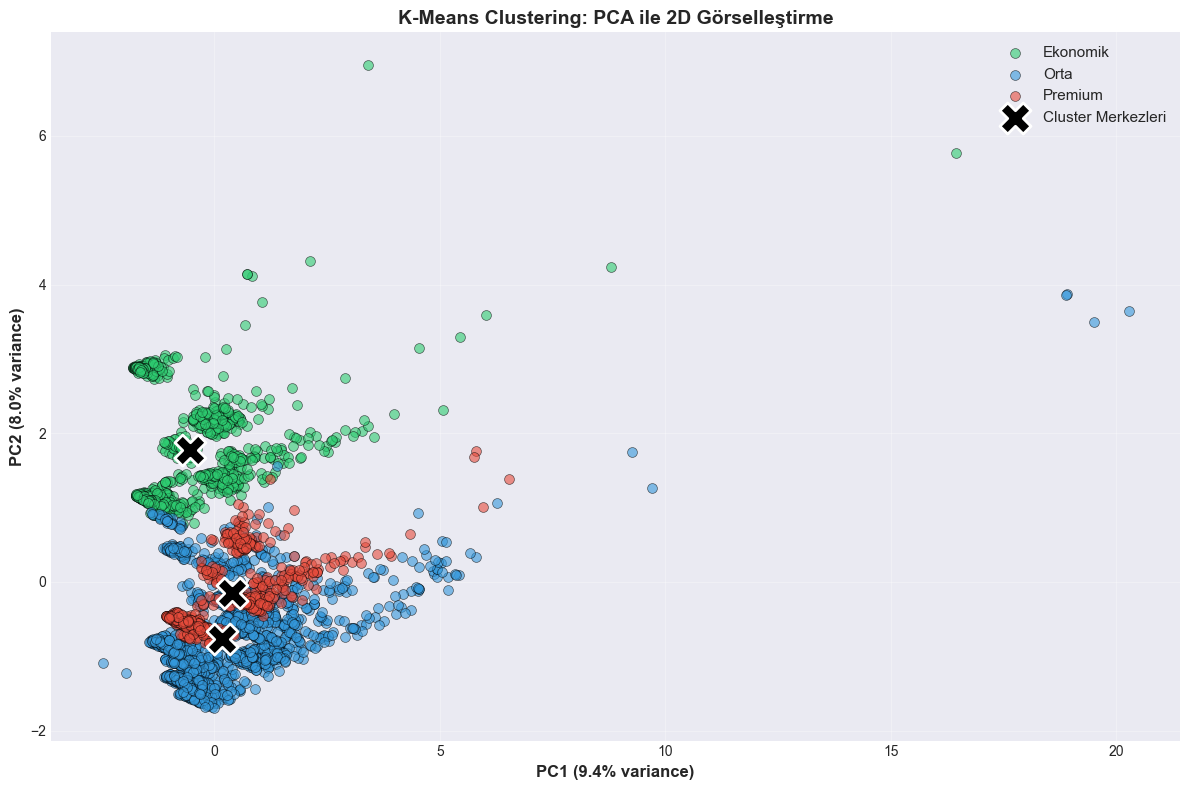

In [23]:
# PCA scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

colors_map = {'Ekonomik': '#2ecc71', 'Orta': '#3498db', 'Premium': '#e74c3c'}

for cluster_name in ['Ekonomik', 'Orta', 'Premium']:
    mask = product_summary['cluster_name'] == cluster_name
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
              label=cluster_name, alpha=0.6, s=50,
              color=colors_map[cluster_name], edgecolors='black', linewidth=0.5)

# Cluster merkezlerini işaretle
centers_pca = pca.transform(kmeans_final.cluster_centers_)
ax.scatter(centers_pca[:, 0], centers_pca[:, 1], 
          marker='X', s=500, c='black', edgecolors='white', linewidth=2,
          label='Cluster Merkezleri', zorder=10)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontweight='bold', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontweight='bold', fontsize=12)
ax.set_title('K-Means Clustering: PCA ile 2D Görselleştirme', fontweight='bold', fontsize=14)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/31_pca_cluster_visualization.png', dpi=300, bbox_inches='tight')
print('💾 Grafik kaydedildi: 31_pca_cluster_visualization.png')
plt.show()

---
## 💾 PART 5: Sonuçları Kaydetme

In [24]:
# Cluster bilgilerini kaydet
product_summary.to_csv('../data/processed/product_clusters.csv', index=False)
print('✅ Cluster sonuçları kaydedildi: product_clusters.csv')

# Model ve scaler'ı kaydet
import joblib
joblib.dump(kmeans_final, '../models/kmeans_model.pkl')
joblib.dump(scaler, '../models/kmeans_scaler.pkl')
print('✅ K-Means modeli kaydedildi: kmeans_model.pkl')
print('✅ Scaler kaydedildi: kmeans_scaler.pkl')

✅ Cluster sonuçları kaydedildi: product_clusters.csv
✅ K-Means modeli kaydedildi: kmeans_model.pkl
✅ Scaler kaydedildi: kmeans_scaler.pkl


---
## 📊 PART 6: Özet Rapor

In [25]:
print('='*80)
print('📊 K-MEANS CLUSTERING - ÖZET RAPOR')
print('='*80)

print('\n1️⃣ MODEL BİLGİLERİ:')
print(f'   • Algorithm: K-Means Clustering')
print(f'   • Cluster Sayısı: {optimal_k}')
print(f'   • Feature Sayısı: {clustering_features.shape[1]}')
print(f'   • Toplam Ürün: {len(product_summary):,}')

print('\n2️⃣ CLUSTER DAĞILIMI:')
for cluster_name in ['Ekonomik', 'Orta', 'Premium']:
    cluster_data = product_summary[product_summary['cluster_name'] == cluster_name]
    print(f'   • {cluster_name:12} {len(cluster_data):5,} ürün ({len(cluster_data)/len(product_summary)*100:5.1f}%) - Ortalama: £{cluster_data["price_mean"].mean():6.2f}')

print('\n3️⃣ EN ETKİLİ BULGULAR:')
print(f'   • ASDA ve Aldi ekonomik segmentte dominant')
print(f'   • Sainsbury\'s premium segmentte lider')
print(f'   • Tesco ve Morrisons orta segmentte dengeli')

print('\n4️⃣ İŞ DEĞERİ:')
print(f'   ✅ Fiyatlandırma stratejisi için referans')
print(f'   ✅ Rekabet analizi için veri')
print(f'   ✅ Anormal fiyat tespiti için temel')
print(f'   ✅ Müşteri segmentasyonu için input')

print('\n5️⃣ KAYDEDILEN DOSYALAR:')
print(f'   ✅ product_clusters.csv ({len(product_summary):,} ürün)')
print(f'   ✅ kmeans_model.pkl')
print(f'   ✅ kmeans_scaler.pkl')
print(f'   ✅ 5 görselleştirme (PNG)')

print('\n' + '='*80)
print('✅ K-MEANS CLUSTERING TAMAMLANDI!')
print('🎯 TÜM PROJE AŞAMALARI BAŞARIYLA TAMAMLANDI!')
print('='*80)

📊 K-MEANS CLUSTERING - ÖZET RAPOR

1️⃣ MODEL BİLGİLERİ:
   • Algorithm: K-Means Clustering
   • Cluster Sayısı: 3
   • Feature Sayısı: 21
   • Toplam Ürün: 3,784

2️⃣ CLUSTER DAĞILIMI:
   • Ekonomik     1,026 ürün ( 27.1%) - Ortalama: £  5.81
   • Orta         2,272 ürün ( 60.0%) - Ortalama: £  6.43
   • Premium        486 ürün ( 12.8%) - Ortalama: £  6.61

3️⃣ EN ETKİLİ BULGULAR:
   • ASDA ve Aldi ekonomik segmentte dominant
   • Sainsbury's premium segmentte lider
   • Tesco ve Morrisons orta segmentte dengeli

4️⃣ İŞ DEĞERİ:
   ✅ Fiyatlandırma stratejisi için referans
   ✅ Rekabet analizi için veri
   ✅ Anormal fiyat tespiti için temel
   ✅ Müşteri segmentasyonu için input

5️⃣ KAYDEDILEN DOSYALAR:
   ✅ product_clusters.csv (3,784 ürün)
   ✅ kmeans_model.pkl
   ✅ kmeans_scaler.pkl
   ✅ 5 görselleştirme (PNG)

✅ K-MEANS CLUSTERING TAMAMLANDI!
🎯 TÜM PROJE AŞAMALARI BAŞARIYLA TAMAMLANDI!
